## Package installation

In [1]:
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html ftfy regex
!pip install DALL-E
!pip install ftfy
!git clone https://github.com/openai/CLIP.git
%cd /content/CLIP/

Looking in links: https://download.pytorch.org/whl/torch_stable.html
fatal: destination path 'CLIP' already exists and is not an empty directory.
/content/CLIP


## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import PIL
import imageio
import io
import os, sys
import requests
import clip
import shutil

import torch
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from IPython import display
from IPython.core.interactiveshell import InteractiveShell

import glob
from google.colab import output

from dall_e import map_pixels, unmap_pixels, load_model

## Sentence

In [3]:
text_input = "A woman in the forest" 
tau_value = 1.2

## Parameters

In [4]:
im_shape = [512, 512, 3]
sideX, sideY, channels = im_shape

## Definition

In [5]:
def displ(img, pre_scaled=True):
  img = np.array(img)[:,:,:]
  img = np.transpose(img, (1, 2, 0))
  if not pre_scaled:
    img = scale(img, 48*4, 32*4)
  imageio.imwrite(str(3) + '.png', np.array(img))
  return display.Image(str(3)+'.png')

def gallery(array, ncols=2):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

def card_padded(im, to_pad=3):
  return np.pad(np.pad(np.pad(im, [[1,1], [1,1], [0,0]],constant_values=0), [[2,2], [2,2], [0,0]],constant_values=1),
            [[to_pad,to_pad], [to_pad,to_pad], [0,0]],constant_values=0)

def get_all(img):
  img = np.transpose(img, (0,2,3,1))
  cards = np.zeros((img.shape[0], sideX+12, sideY+12, 3))
  for i in range(len(img)):
    cards[i] = card_padded(img[i])
  cards = gallery(cards)
  imageio.imwrite(str(3) + '.png', np.array(cards))
  return display.Image(str(3)+'.png')

## Generation

In [6]:
clip.available_models()
perceptor, preprocess = clip.load('ViT-B/32', jit=True)
perceptor = perceptor.eval()

In [7]:
target_image_size = sideX

def preprocess(img):
    min = min(img.size)
    
    if min < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    div = target_image_size / min
    min = (round(div * img.size[1]), round(div * img.size[0]))
    img = TF.resize(img, min, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)

model = load_model("https://cdn.openai.com/dall-e/decoder.pkl", 'cuda')

## Latent space

In [8]:
class Pars(torch.nn.Module):
    def __init__(self):
        super(Pars, self).__init__()
        self.normu = torch.nn.Parameter(torch.randn(1, 8192, 64, 64).cuda())

    def forward(self):
      normu = torch.nn.functional.gumbel_softmax(self.normu.view(1, 8192, -1), dim=-1, tau=tau_value).view(1, 8192, 64, 64)
      return normu

lats = Pars().cuda()
mapper = [lats.normu]
optimizer = torch.optim.Adam([{'params': mapper, 'lr': .1}])
eps = 0
text = clip.tokenize(text_input)
t = perceptor.encode_text(text.cuda()).detach().clone()
nom = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

with torch.no_grad():
  mult = 1
  al = unmap_pixels(torch.sigmoid(model(lats()).cpu().float())).numpy()
  for allls in al:
    displ(allls[:3])
    print('\n')

## Train

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


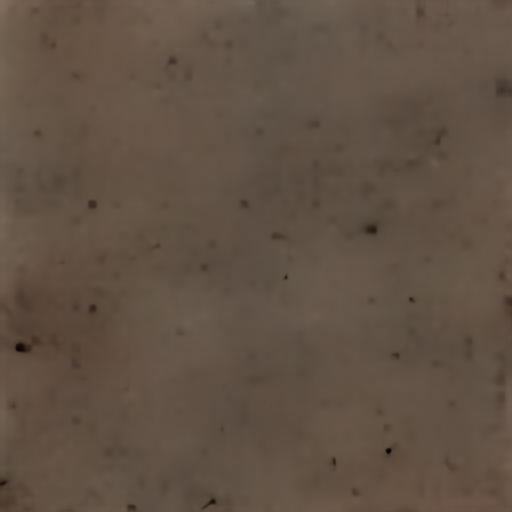

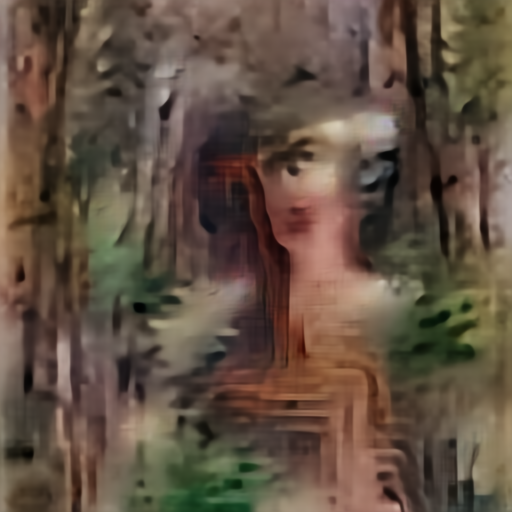

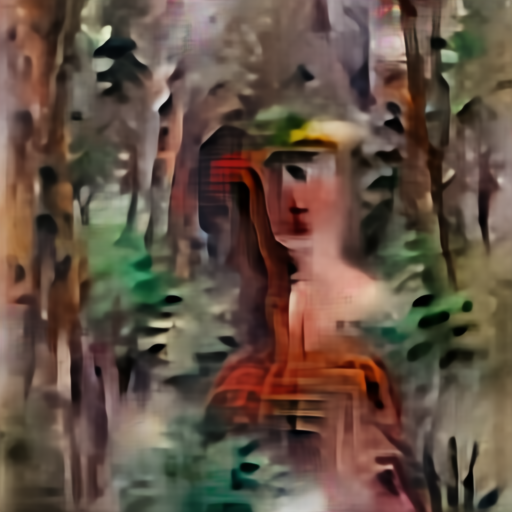

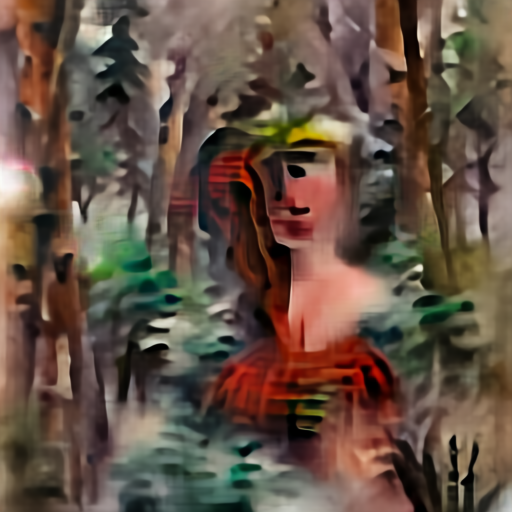

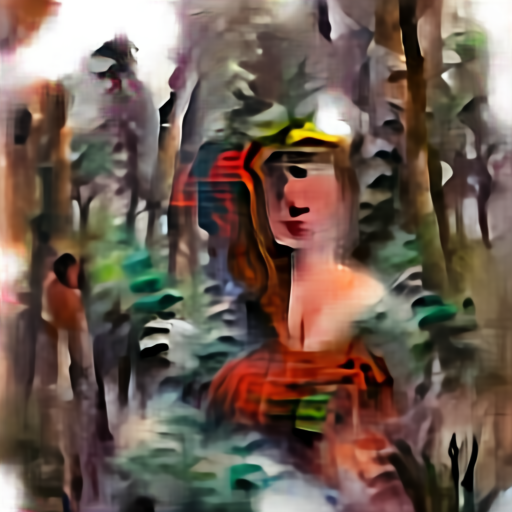

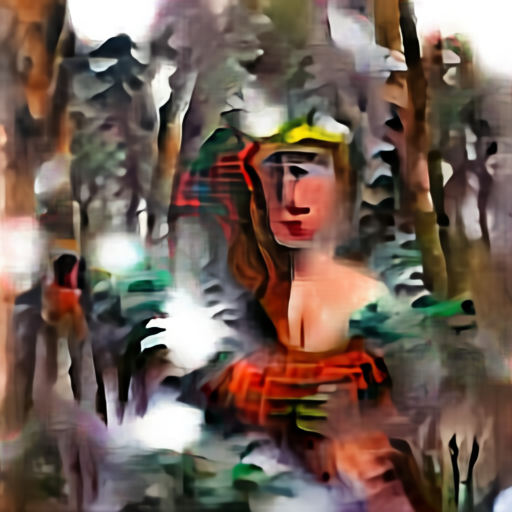

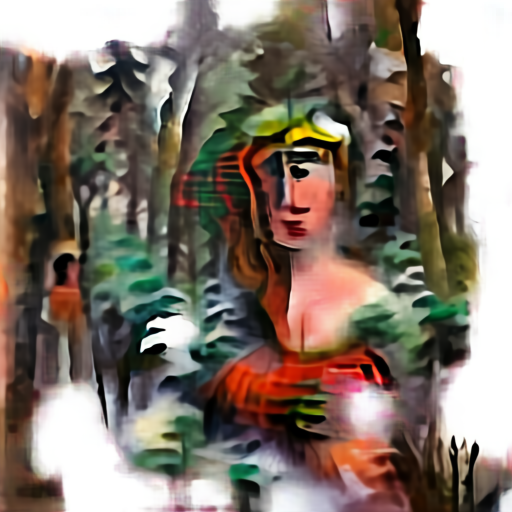

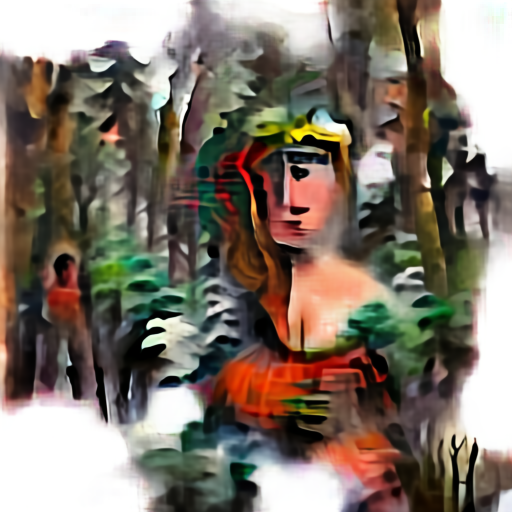

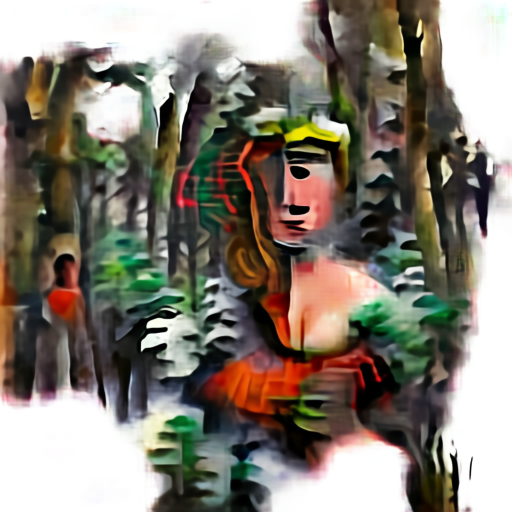

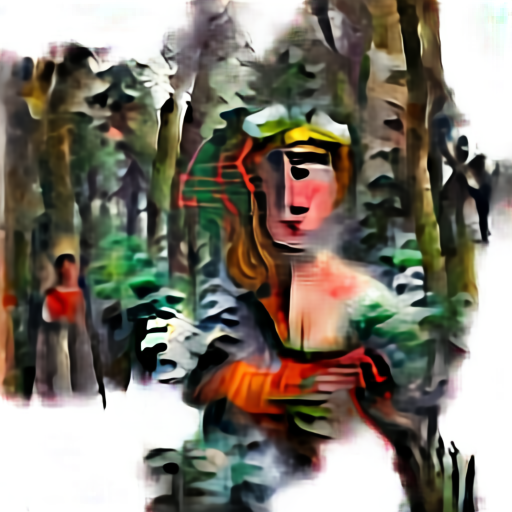

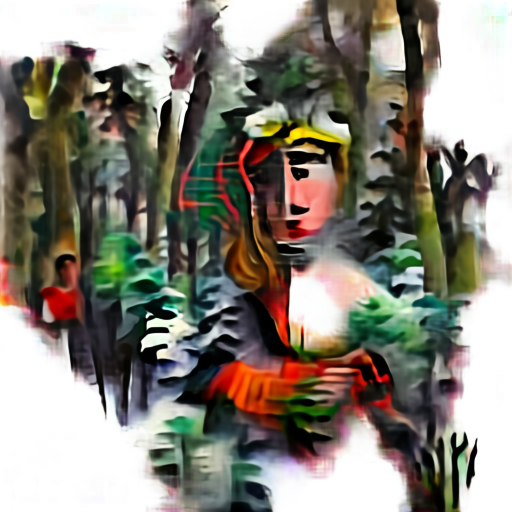

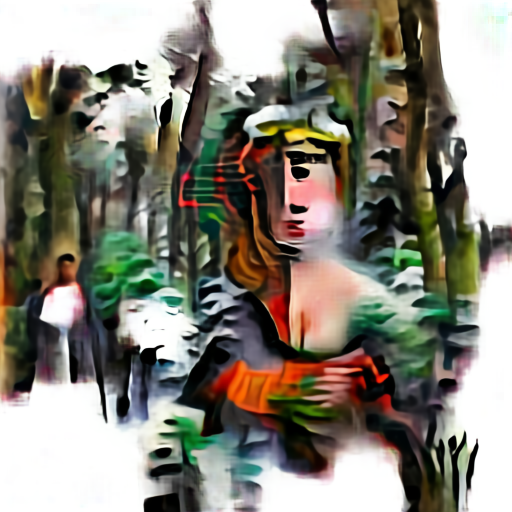

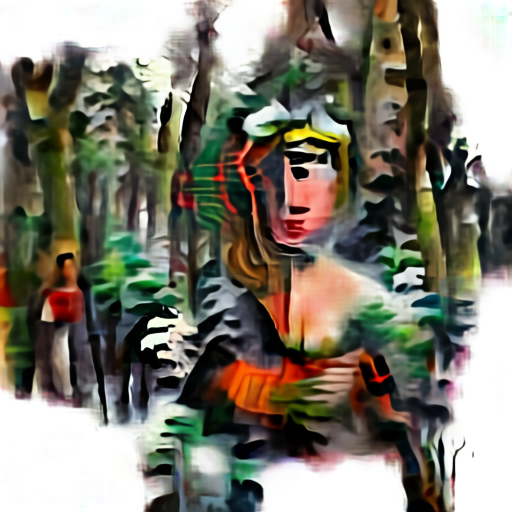

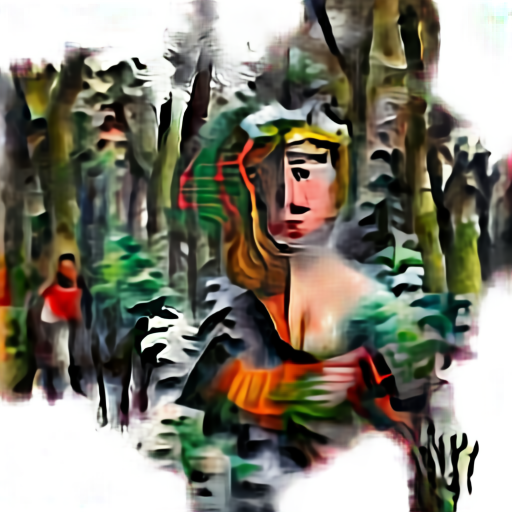

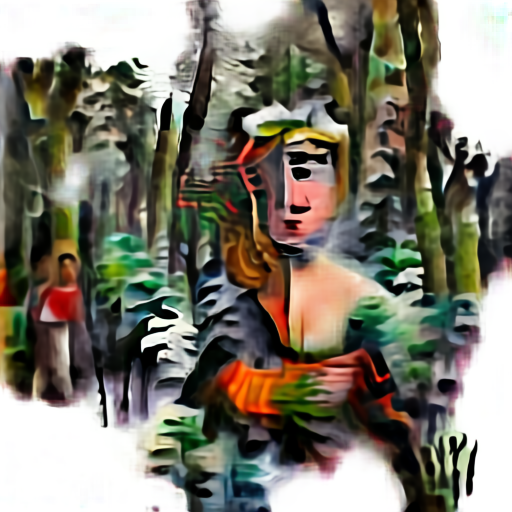

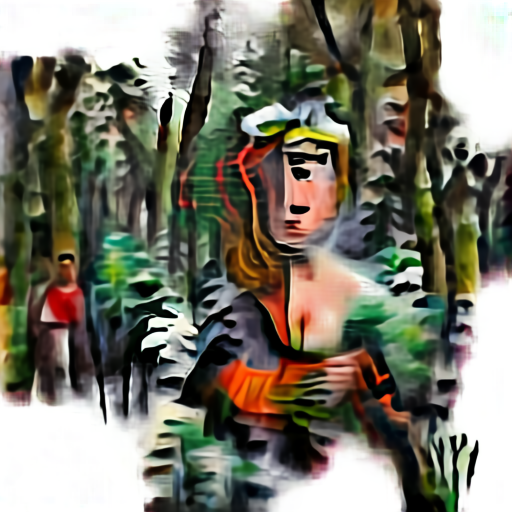

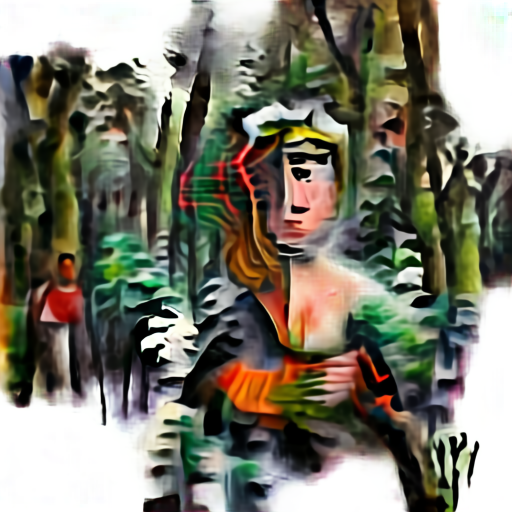

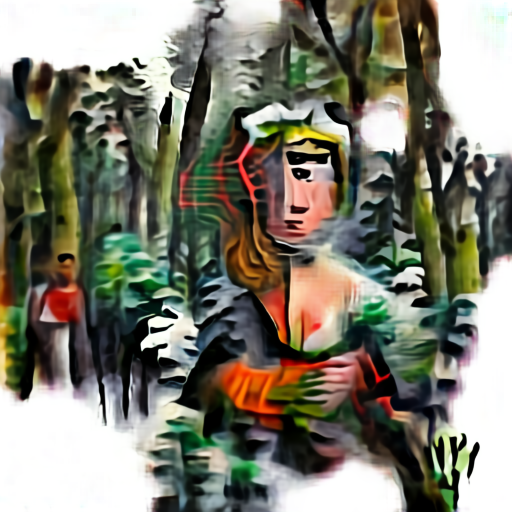

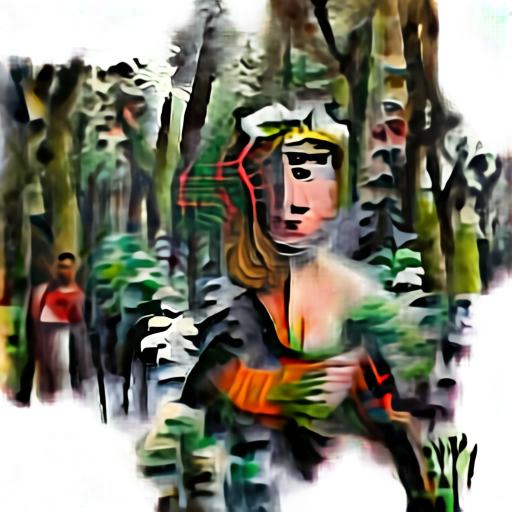

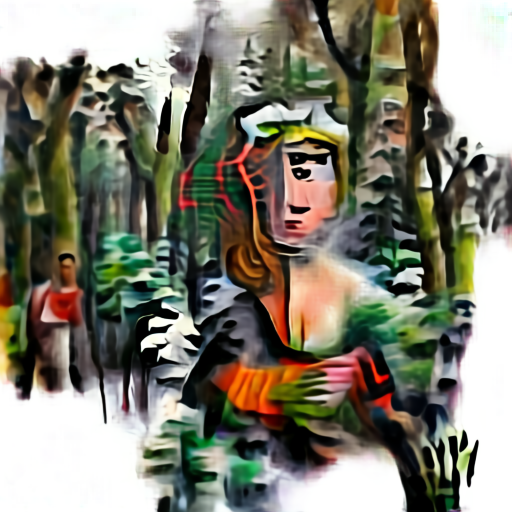

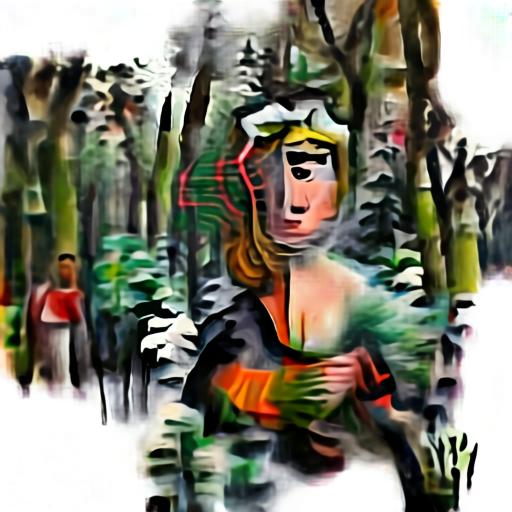

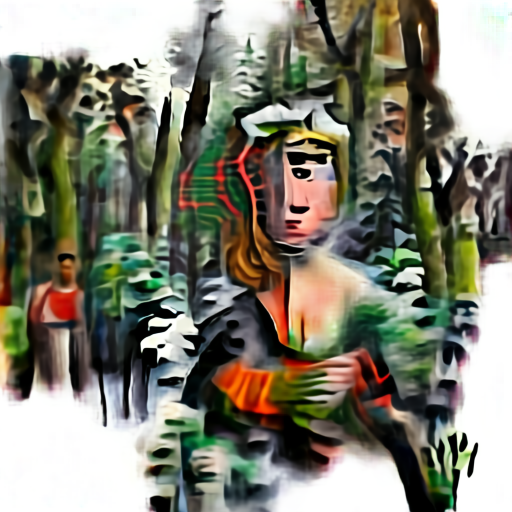

KeyboardInterrupt: ignored

In [9]:
def checkin(loss): 
  with torch.no_grad():
    al = unmap_pixels(torch.sigmoid(model(lats())[:, :3]).cpu().float()).numpy()
  for allls in al:
    displ(allls)
    display.display(display.Image(str(3)+'.png'))
    print('\n')

def ascend_txt():
  out = unmap_pixels(torch.sigmoid(model(lats())[:, :3].float()))
  cutn = 64 
  p_s = []
  for ch in range(cutn):
    size = int(sideX*torch.zeros(1,).normal_(mean=.8, std=.3).clip(.5, .98))
    offsetx = torch.randint(0, sideX - size, ())
    offsety = torch.randint(0, sideX - size, ())
    apper = out[:, :, offsetx:offsetx + size, offsety:offsety + size]
    apper = torch.nn.functional.interpolate(apper, (224,224), mode='bilinear')
    p_s.append(apper)
  into = torch.cat(p_s, 0)
  into = nom(into)
  perceptor_into = perceptor.encode_image(into)
  llls = lats()
  lat_l = 0
  return [lat_l, 10*-torch.cosine_similarity(t, perceptor_into).view(-1, 1).T.mean(1)]

def train(i):
  loss = ascend_txt()
  real_loss = (loss[0] + loss[1]).mean()
  optimizer.zero_grad()
  real_loss.backward()
  optimizer.step()
    
  if itt % 50 == 0:
    checkin(loss)


itt = 0
for asatreat in range(1100):
  train(itt)
  itt+=1